In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['tcp_flag_cwr']
del dataset['tcp_flag_ecn']
del dataset['tcp_flag_urg']
del dataset['ip_len']
del dataset['tcp_flag_psh']
del dataset['tcp_flag_fin']
del dataset['prebuffering']
del dataset['Time']

print(dataset.columns)

Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')


In [3]:
X_train = [None] * (len(dataset.columns)-1)
X_test = [None] * (len(dataset.columns)-1)
y_train = [None] 
y_test = [None] 

len_rate = 0.02

grouped = dataset.groupby(['delay','capture']) 
#print(grouped.mean())

for id, data in grouped:
    spl = int(data.shape[0] * split);
    X_train = np.vstack((X_train,data.values[0:spl,:-1]))
    X_test = np.vstack((X_test,data.values[spl:,:-1]))
    y_train = np.vstack((y_train,np.reshape(data.values[0:spl,-1],(-1,1))))
    y_test = np.vstack((y_test,np.reshape(data.values[spl:,-1],(-1,1))))

X_train = X_train[1:]
X_test = X_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]    

X_train = pd.DataFrame(X_train,columns=dataset.columns[:-1])
X_test = pd.DataFrame(X_test,columns=dataset.columns[:-1])
y_train = pd.DataFrame(y_train,columns=['y'])
y_test = pd.DataFrame(y_test,columns=['y'])

del X_train['delay']
del X_train['capture']
del dataset['delay']
del dataset['capture']

del X_test['delay']
del X_test['capture']

#print('X_train: '+str(len(X_train))+' | X_test: '+str(len(X_test)) + ' | y_train: '+str(len(y_train)) + '| y_test: '+str(len(y_test)))
print(X_train.columns)
#print(X_train)

Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2'],
      dtype='object')


In [4]:
norm = preprocessing.MinMaxScaler()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
X_train2 = X_train[['pkt_len','tcp_hea_len','tcp_win_si2']].values
X_test2 = X_test[['pkt_len','tcp_hea_len','tcp_win_si2']].values
#print(X_test2)

X_train_norm2 = norm.fit_transform(X_train2)
X_test_norm2 = norm.transform(X_test2)
#print(X_test_std2)

X_train_norm = X_train
X_train_norm[['pkt_len','tcp_hea_len','tcp_win_si2']] = X_train_norm2
print(X_train_norm.values)

X_test_norm = X_test
X_test_norm[['pkt_len','tcp_hea_len','tcp_win_si2']] = X_test_norm2

#print(X_test_std)

[[0.00000000e+00 1.63043478e-02 3.33333333e-01 ... 0.00000000e+00
  1.00000000e+00 1.25384557e-01]
 [3.27000000e-02 1.63043478e-02 3.33333333e-01 ... 0.00000000e+00
  1.00000000e+00 9.94872580e-01]
 [2.00000000e-04 8.15217391e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.91826739e-03]
 ...
 [1.00000000e-04 1.63043478e-02 3.33333333e-01 ... 0.00000000e+00
  0.00000000e+00 3.91826739e-03]
 [2.90000000e-03 9.72826087e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.83163695e-01]
 [1.00000000e-04 1.63043478e-02 3.33333333e-01 ... 0.00000000e+00
  0.00000000e+00 3.91826739e-03]]


In [5]:
std = preprocessing.StandardScaler()
X_train_std2 = std.fit_transform(X_train2)
X_test_std2 = std.transform(X_test2)

X_train_std = X_train
X_train_std[['pkt_len','tcp_hea_len','tcp_win_si2']] = X_train_std2

X_test_std = X_test
X_test_std[['pkt_len','tcp_hea_len','tcp_win_si2']] = X_test_std2


In [6]:
import sklearn.metrics as metrics
def compute_metrics (y_test2,y_pred):
    accuracy = metrics.accuracy_score(y_test2.astype('int'),y_pred.astype('int'))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    precision = metrics.precision_score(y_test2.astype('int'),y_pred.astype('int'))
    print("Precision: %.2f%%" % (precision * 100.0))
    
    recall = metrics.recall_score(y_test2.astype('int'),y_pred.astype('int'))
    print("Recall: %.2f%%" % (recall * 100.0))
    
    F1Score = metrics.f1_score(y_test2.astype('int'),y_pred.astype('int'))
    print("F1 Score: %.2f%%" % (F1Score * 100.0))
    
    print('CONFUSION MATRIX:')
    conf_m = metrics.confusion_matrix(y_test2.astype('int'),y_pred.astype('int'))
    print(conf_m)
    print()

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def RandomForest (X_train,y_train,X_test,y_test):
    for i in range(1,5):
        print('dep: '+str(i))
        rfc = RandomForestClassifier(max_depth=i, random_state=0)
        rfc.fit(X_train,y_train)
        y_pred = rfc.predict(X_test)
        compute_metrics(y_test,y_pred)


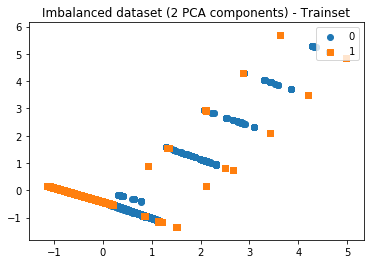

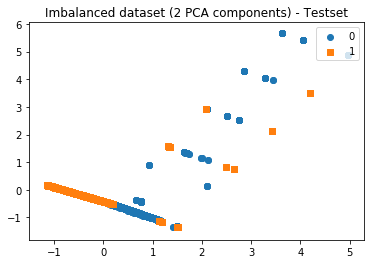



 RANDOM FOREST FOR 2 COMPONENTS
dep: 1
Accuracy: 97.86%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
CONFUSION MATRIX:
[[301412      0]
 [  6600      0]]

dep: 2
Accuracy: 97.86%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
CONFUSION MATRIX:
[[301412      0]
 [  6600      0]]

dep: 3
Accuracy: 97.86%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
CONFUSION MATRIX:
[[301412      0]
 [  6600      0]]

dep: 4
Accuracy: 97.86%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
CONFUSION MATRIX:
[[301412      0]
 [  6600      0]]



c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\usuario\pycharmprojects\s

In [7]:
Train_std = pd.concat([X_train_std,y_train],axis=1) 
Test_std = pd.concat([X_test_std,y_test],axis=1) 

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2c = pca.fit_transform(X_train_std.values)
X_test_2c = pca.transform(X_test_std.values)
plot_2d_space(X_train_2c, y_train.values.astype('int').T.ravel(), 'Imbalanced dataset (2 PCA components) - Trainset')
plot_2d_space(X_test_2c, y_test.values.astype('int').T.ravel(), 'Imbalanced dataset (2 PCA components) - Testset')

print('\n\n RANDOM FOREST FOR 2 COMPONENTS')
RandomForest(X_train_2c,y_train.values.astype('int').T.ravel(),X_test_2c,y_test.values.astype('int').T.ravel())

In [8]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros,y_ros = ros.fit_sample(X_train_std.values,y_train.values.astype('int').T.ravel())
RandomForest(X_ros,y_ros,X_test_std.values,y_test.values.astype('int').T.ravel())

print('\n\n RANDOM FOREST FOR 2 COMPONENTS')
X_ros_2c,y_ros_2c = ros.fit_sample(X_train_2c,y_train.values.astype('int').T.ravel())
RandomForest(X_ros_2c,y_ros,X_test_2c,y_test.values.astype('int').T.ravel())


dep: 1
Accuracy: 59.24%
Precision: 2.37%
Recall: 44.85%
F1 Score: 4.50%
CONFUSION MATRIX:
[[179497 121915]
 [  3640   2960]]

dep: 2
Accuracy: 59.45%
Precision: 2.38%
Recall: 44.82%
F1 Score: 4.52%
CONFUSION MATRIX:
[[180140 121272]
 [  3642   2958]]

dep: 3
Accuracy: 73.15%
Precision: 1.76%
Recall: 21.06%
F1 Score: 3.25%
CONFUSION MATRIX:
[[223910  77502]
 [  5210   1390]]

dep: 4
Accuracy: 73.25%
Precision: 1.76%
Recall: 20.92%
F1 Score: 3.24%
CONFUSION MATRIX:
[[224245  77167]
 [  5219   1381]]



 RANDOM FOREST FOR 2 COMPONENTS
dep: 1
Accuracy: 94.28%
Precision: 4.43%
Recall: 8.12%
F1 Score: 5.74%
CONFUSION MATRIX:
[[289858  11554]
 [  6064    536]]

dep: 2
Accuracy: 76.62%
Precision: 1.03%
Recall: 10.47%
F1 Score: 1.88%
CONFUSION MATRIX:
[[235304  66108]
 [  5909    691]]

dep: 3
Accuracy: 83.06%
Precision: 1.47%
Recall: 10.47%
F1 Score: 2.58%
CONFUSION MATRIX:
[[255130  46282]
 [  5909    691]]

dep: 4
Accuracy: 83.33%
Precision: 1.49%
Recall: 10.38%
F1 Score: 2.60%
CONFUSION MAT

In [9]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus,y_rus = rus.fit_sample(X_train_std.values,y_train.values.astype('int').T.ravel())
RandomForest(X_rus,y_rus,X_test_std.values,y_test.values.astype('int').T.ravel())
print('\n\n RANDOM FOREST FOR 2 COMPONENTS\n')
X_rus_2c,y_rus_2c = rus.fit_sample(X_train_2c,y_train.values.astype('int').T.ravel())
RandomForest(X_rus_2c,y_rus,X_test_2c,y_test.values.astype('int').T.ravel())

dep: 1
Accuracy: 60.63%
Precision: 2.42%
Recall: 44.24%
F1 Score: 4.59%
CONFUSION MATRIX:
[[183825 117587]
 [  3680   2920]]

dep: 2
Accuracy: 59.59%
Precision: 2.38%
Recall: 44.71%
F1 Score: 4.53%
CONFUSION MATRIX:
[[180603 120809]
 [  3649   2951]]

dep: 3
Accuracy: 73.20%
Precision: 1.76%
Recall: 21.02%
F1 Score: 3.25%
CONFUSION MATRIX:
[[224069  77343]
 [  5213   1387]]

dep: 4
Accuracy: 74.93%
Precision: 1.94%
Recall: 21.64%
F1 Score: 3.57%
CONFUSION MATRIX:
[[229364  72048]
 [  5172   1428]]



 RANDOM FOREST FOR 2 COMPONENTS

dep: 1
Accuracy: 94.28%
Precision: 4.43%
Recall: 8.12%
F1 Score: 5.74%
CONFUSION MATRIX:
[[289857  11555]
 [  6064    536]]

dep: 2
Accuracy: 82.94%
Precision: 1.46%
Recall: 10.47%
F1 Score: 2.56%
CONFUSION MATRIX:
[[254769  46643]
 [  5909    691]]

dep: 3
Accuracy: 82.94%
Precision: 1.46%
Recall: 10.47%
F1 Score: 2.56%
CONFUSION MATRIX:
[[254780  46632]
 [  5909    691]]

dep: 4
Accuracy: 82.00%
Precision: 2.58%
Recall: 20.17%
F1 Score: 4.58%
CONFUSION MA

In [10]:
'''from imblearn.under_sampling import TomekLinks
tl = TomekLinks(str='majority')
X_tl, y_tl = tl.fit_sample(X_train_std.values, y_train.values.astype('int').T.ravel())
RandomForest(X_tl, y_tl,X_test_std.values,y_test.values.astype('int').T.ravel())
'''

"from imblearn.under_sampling import TomekLinks\ntl = TomekLinks(str='majority')\nX_tl, y_tl = tl.fit_sample(X_train_std.values, y_train.values.astype('int').T.ravel())\nRandomForest(X_tl, y_tl,X_test_std.values,y_test.values.astype('int').T.ravel())\n"

In [11]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_sample(X_train_std.values, y_train.values.astype('int').T.ravel())
RandomForest(X_cc, y_cc,X_test_std.values,y_test.values.astype('int').T.ravel())
print('\n\n RANDOM FOREST FOR 2 COMPONENTS')
X_cc_2c,y_cc_2c = cc.fit_sample(X_train_2c,y_train.values.astype('int').T.ravel())
RandomForest(X_cc_2c,y_cc,X_test_2c,y_test.values.astype('int').T.ravel())

MemoryError: Unable to allocate array with shape (106431, 106431) and data type float64

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(str='minority')
X_sm, y_sm = smote.fit_sample(X_train_std.values, y_train.values.astype('int').T.ravel())
RandomForest(X_sm, y_sm,X_test_std.values,y_test.values.astype('int').T.ravel())

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(str='auto')
X_smt, y_smt = smt.fit_sample(X_train_std.values, y_train.values.astype('int').T.ravel())
RandomForest(X_smt, y_smt,X_test_std.values,y_test.values.astype('int').T.ravel())
